In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from medpy.metric import dc, assd
import torch.nn.functional as F
import torchio as tio
import nibabel as nib

In [26]:
# import torch

# if torch.cuda.is_available():
#     gpu = torch.cuda.current_device()
#     gpu_properties = torch.cuda.get_device_properties(gpu)
#     print(f"GPU Name: {gpu_properties.name}")
#     print(f"GPU Memory (in bytes): {gpu_properties.total_memory}")
#     print(f"GPU Memory (in GB): {gpu_properties.total_memory / (1024 ** 3)}")
# else:
#     print("No GPU available.")


In [27]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.nn.functional as F

class BrainSegmentationDataset(Dataset):
    def __init__(self, t1c_dir, t2f_dir, seg_dir, transforms=None):
        self.t1c_dir = t1c_dir
        self.t2f_dir = t2f_dir
        self.seg_dir = seg_dir
        self.transforms = transforms

        # Create a list of all seg images (patient + slice)
        self.seg_files = [os.path.join(root, file) for root, _, files in os.walk(seg_dir) 
                          for file in files if os.path.getsize(os.path.join(root, file)) > 141]

    def __len__(self):
        return len(self.seg_files)

    def __getitem__(self, idx):
        seg_img_path = self.seg_files[idx]
        
        mask = Image.open(seg_img_path).convert('L')
        
        mask = np.array(mask, dtype = np.int64)
        
        background_mask = (mask == 0).astype(np.float32)
        class1_mask = (mask == 85).astype(np.float32)
        class2_mask = (mask == 170).astype(np.float32)
        class3_mask = (mask == 255).astype(np.float32)
        
        mask = np.dstack([background_mask, class1_mask, class2_mask, class3_mask])
        mask = np.argmax(mask, axis = 2)
        
        # Corresponding input images
        t1c_img_path = seg_img_path.replace('seg', 't1n')
        t1c_img = Image.open(t1c_img_path).convert('L')  # load and convert t1c image
        t1c_tensor = torch.from_numpy(np.array(t1c_img,dtype = np.float32)[None, ...])/255.0
#         t1c_tensor = self.transforms(t1c_img)  # transform to tensor

        t2f_img_path = seg_img_path.replace('seg', 't2f')
        t2f_img = Image.open(t2f_img_path)  # load and convert t2f image
        t2f_tensor = torch.from_numpy(np.array(t2f_img,dtype = np.float32)[None, ...])/255.0
#         t2f_tensor = self.transforms(t2f_img)  # transform to tensor

        # Stack t1c and t2f tensors along the channel dimension
        inputs = torch.cat((t1c_tensor, t2f_tensor), dim=0)

        return inputs, mask


In [28]:
from torchvision import transforms

data_transforms = transforms.Compose([
     # You can modify this as per your model's input size
    transforms.ToTensor(),
])

dataset = BrainSegmentationDataset(t1c_dir="BraTS_2023_small/t1nSliced", t2f_dir="BraTS_2023_small/t2fSliced", seg_dir="BraTS_2023_small/segSliced", transforms=data_transforms)


In [29]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training set and validation set
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create a DataLoader for both sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [30]:
print(len(train_dataset))
print(len(train_loader))
data, labels = next(iter(train_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
data, labels = next(iter(val_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)


17713
554
Data shape: torch.Size([32, 2, 256, 256])
Labels shape: torch.Size([32, 256, 256])
Data shape: torch.Size([32, 2, 256, 256])
Labels shape: torch.Size([32, 256, 256])


In [31]:
def plot_preds_and_masks(preds, masks):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    for i, (pred, mask) in enumerate(zip(preds, masks)):
#         pred = torch.argmax(pred, dim=0)  # Convert from one-hot encoding to class labels
#         mask = torch.argmax(mask, dim=0)  # Convert from one-hot encoding to class labels

        axs[0, i].imshow(pred.cpu().detach().numpy(), cmap = 'gray')
        axs[0, i].title.set_text("Predicted")
        axs[1, i].imshow(mask.cpu().detach().numpy(), cmap = 'gray')
        axs[1, i].title.set_text("Ground Truth")
    plt.show()


In [32]:
def compute_metrics(pred, target):
    assert pred.shape == target.shape
    batch_size, num_classes, _, _ = pred.shape
    DSCs = []
    ASSDs = []
    for image_idx in range(batch_size):
        dsc_per_class = []
        assd_per_class = []
        for class_idx in range(num_classes):
            pred_class = pred[image_idx, class_idx]
            target_class = target[image_idx, class_idx]

            # Check if the prediction and the target contain any objects
            pred_has_object = np.count_nonzero(pred_class) > 0
            target_has_object = np.count_nonzero(target_class) > 0
            
            if pred_has_object and target_has_object:
                dsc = dc(pred_class, target_class)
                assd_val = assd(pred_class, target_class)
            elif not pred_has_object and not target_has_object:
                dsc = 1.0  # perfect similarity
                assd_val = 0.0  # no distance
            else:
                dsc = 0.0  # no overlap
                assd_val = 362  # maximum distance

            dsc_per_class.append(dsc)
            assd_per_class.append(assd_val)
        
        DSCs.append(dsc_per_class)
        ASSDs.append(assd_per_class)
    DSCs = np.array(DSCs)
    ASSDs = np.array(ASSDs)
        
    return np.mean(DSCs, axis = 0), np.mean(ASSDs, axis = 0)

In [33]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(F.relu(g1 + x1, inplace=True))
        return x * psi

In [34]:
# class UNet(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(UNet, self).__init__()

#         # Downsample path
#         self.conv1 = self.double_conv(in_channels, 64)
#         self.pool1 = nn.MaxPool2d(2)
#         self.conv2 = self.double_conv(64, 128)
#         self.pool2 = nn.MaxPool2d(2)
#         self.conv3 = self.double_conv(128, 256)
#         self.pool3 = nn.MaxPool2d(2)
#         self.conv4 = self.double_conv(256, 512)
#         self.pool4 = nn.MaxPool2d(2)

        
#         self.attention_block1 = AttentionBlock(F_g=512, F_l=512, F_int=256)
#         self.attention_block2 = AttentionBlock(F_g=256, F_l=256, F_int=128)
#         self.attention_block3 = AttentionBlock(F_g=128, F_l=128, F_int=64)
#         self.attention_block4 = AttentionBlock(F_g=64, F_l=64, F_int=32)
#         # Bottom
#         self.conv5 = self.double_conv(512, 1024)
        

#         # Upsample path
#         self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2)
#         self.conv6 = self.double_conv(1024, 512)
#         self.up7 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
#         self.conv7 = self.double_conv(512, 256)
#         self.up8 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
#         self.conv8 = self.double_conv(256, 128)
#         self.up9 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
#         self.conv9 = self.double_conv(128, 64)

#         # Output
#         self.conv10 = nn.Conv2d(64, out_channels, kernel_size = 1)

#     def double_conv(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
#             nn.ReLU(inplace = True),
#             nn.BatchNorm2d(out_channels),
#             nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
#             nn.ReLU(inplace = True),
#             nn.BatchNorm2d(out_channels)
            
#         )

#     def forward(self, x):
#         # Downsample path
#         c1 = self.conv1(x)
#         p1 = self.pool1(c1)
#         c2 = self.conv2(p1)
#         p2 = self.pool2(c2)
#         c3 = self.conv3(p2)
#         p3 = self.pool3(c3)
#         c4 = self.conv4(p3)
#         p4 = self.pool4(c4)

#         # Bottom
#         c5 = self.conv5(p4)

#         # Upsample path
#         up6 = self.up6(c5)
#         # print(f"up6 size: {up6.size()}, c4 size: {c4.size()}")
#         merge6 = torch.cat([up6, c4], dim = 1)
#         c6 = self.conv6(merge6)
#         up7 = self.up7(c6)
#         # print(f"up7 size: {up7.size()}, c3 size: {c3.size()}")
#         merge7 = torch.cat([up7, c3], dim = 1)
#         c7 = self.conv7(merge7)
#         up8 = self.up8(c7)
#         # print(f"up8 size: {up8.size()}, c2 size: {c2.size()}")
#         merge8 = torch.cat([up8, c2], dim = 1)
#         c8 = self.conv8(merge8)
#         up9 = self.up9(c8)
#         # print(f"up9 size: {up9.size()}, c1 size: {c1.size()}")
#         merge9 = torch.cat([up9, c1], dim = 1)
#         c9 = self.conv9(merge9)

#         # Output
#         out = self.conv10(c9)
#         return out
    
#     def predict(self, x):
#         out = self.forward(x)
#         _, preds = torch.max(out, 1)
#         return preds

In [35]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(F.relu(g1 + x1, inplace=True))
        return x * psi


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Downsample path
        self.conv1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottom
        self.conv5 = self.double_conv(512, 1024)

        # Attention blocks
        self.attention_block1 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.attention_block2 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.attention_block3 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.attention_block4 = AttentionBlock(F_g=64, F_l=64, F_int=32)

        # Upsample path
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2)
        self.conv6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
        self.conv7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
        self.conv8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.conv9 = self.double_conv(128, 64)

        # Output
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size = 1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        # Downsample path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        # Bottom
        c5 = self.conv5(p4)

        # Upsample path
        up6 = self.up6(c5)
        attention_map1 = self.attention_block1(up6, c4)
        merge6 = torch.cat([up6, attention_map1], dim = 1)
        c6 = self.conv6(merge6)

        up7 = self.up7(c6)
        attention_map2 = self.attention_block2(up7, c3)
        merge7 = torch.cat([up7, attention_map2], dim = 1)
        c7 = self.conv7(merge7)

        up8 = self.up8(c7)
        attention_map3 = self.attention_block3(up8, c2)
        merge8 = torch.cat([up8, attention_map3], dim = 1)
        c8 = self.conv8(merge8)

        up9 = self.up9(c8)
        attention_map4 = self.attention_block4(up9, c1)
        merge9 = torch.cat([up9, attention_map4], dim = 1)
        c9 = self.conv9(merge9)

        # Output
        out = self.conv10(c9)
        return out

    def predict(self, x):
        out = self.forward(x)
        _, preds = torch.max(out, 1)
        return preds


In [36]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self, output, target):
        intersection = (output * target).sum(dim=(2, 3))
        union = output.sum(dim=(2, 3)) + target.sum(dim=(2, 3))

        dice_coeff = (2. * intersection + self.eps) / (union + self.eps)
        dice_loss = 1. - dice_coeff

        return dice_loss.mean()


In [37]:
# from tqdm import tqdm
# def train_model(num_epochs):
#     # Create dataset and dataloader for T1
# #     training_dataset_T1 = train_loader
# #     validation_dataset_T1 = val_loader

#     training_dataloader_T1 = train_loader
#     validation_dataloader_T1 = val_loader

#     # Check if saved model exists, if so load it, otherwise initialize a new one
#     model_path = "unet_model_att.pth"
#     if os.path.isfile(model_path):
#         print("Loading model...")
#         model = UNet(in_channels = 2, out_channels = 4)
#         model.load_state_dict(torch.load(model_path))
#         model = model.to(device)
#         print("Model loaded.")
#     else:
#         print("Initializing new model...")
#         model = UNet(in_channels = 2, out_channels = 4).to(device)
#         print("New model initialized.")

#     # Define loss function and optimizer
#     # criterion = nn.CrossEntropyLoss()
#     criterion = DiceLoss()
#     optimizer = optim.Adam(model.parameters(), lr = 0.0001)

#     for epoch in range(num_epochs):
#         print(f"Epoch { epoch + 1 }/{ num_epochs }")
#         print("-------------------------")

#         # Initialize the running loss to zero
#         running_loss = 0.0

#         # Initialize counter for the number of batches
#         num_batches = 0

#         # Initialize the running DSC and ASSD
#         running_train_dsc = []
#         running_train_assd = []

#         # Training phase
#         model.train() 
#         for i, (images, masks) in enumerate(tqdm(training_dataloader_T1)):
#             images = images.to(device)
#             masks = masks.to(device)
# #             masks = masks.float().squeeze(1).permute(0, 3, 2, 1)

#             # Forward pass
#             outputs = model(images)
#             masks_one_hot = F.one_hot(masks, num_classes = 4).permute(0, 3, 1, 2).contiguous().float()
            
#             probs = F.softmax(outputs, dim=1)
#             # loss = criterion(probs, masks)
#             loss = criterion(probs, masks_one_hot)
            
#             # loss = criterion(outputs, masks)

#             # Backward pass and optimization
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             if epoch % 1 == 0 and i == 0:
#                 print("Training Prediction Visualization:")
#                 _, preds = torch.max(outputs[:2], 1)
# #                 print(outputs.shape,masks.shape)
#                 plot_preds_and_masks(preds,masks[:2])

#             # Update the running loss and batch count
#             running_loss += loss.item()
#             num_batches += 1


#             if epoch % 1 == 0:
#                 _, preds = torch.max(outputs, 1)
#                 preds_one_hot = F.one_hot(preds, num_classes = 4)
#                 preds_one_hot = preds_one_hot.permute(0, 3, 1, 2)

#                 masks_one_hot = F.one_hot(masks, num_classes = 4)
#                 masks_one_hot = masks_one_hot.permute(0, 3, 1, 2)

#                 train_dsc, train_assd = compute_metrics(preds_one_hot.cpu().numpy(), masks_one_hot.cpu().numpy())
#                 running_train_dsc.append(train_dsc)
#                 running_train_assd.append(train_assd)


#         # Compute and print the average training loss for this epoch
#         avg_train_loss = running_loss / num_batches
#         print(f"\nAverage Training Loss: {avg_train_loss}")

#         if epoch % 1 == 0:
#             print(f"\nAverage Training DSC: {np.mean(np.array(running_train_dsc), axis = 0)}\nAverage Training ASSD: {np.mean(np.array(running_train_assd), axis = 0)}")

#         # Validation phase
#         model.eval()  # Set model to evaluate mode
#         running_val_loss = 0.0
#         num_val_batches = 0
#         running_val_dsc = []
#         running_val_assd = []

#         with torch.no_grad():  # No need to track gradients in validation phase
#             for i, (val_images, val_masks) in enumerate(tqdm(validation_dataloader_T1)):
#                 val_images = val_images.to(device)
#                 val_masks = val_masks.to(device)

#                 val_outputs = model(val_images)
#                 val_probs = F.softmax(val_outputs, dim=1)
#                 val_masks_one_hot = F.one_hot(val_masks, num_classes = 4).permute(0, 3, 1, 2).contiguous().float()
#                 val_loss = criterion(val_probs, val_masks_one_hot)
                
#                 # val_loss = criterion(val_outputs, val_masks)
                
#                 running_val_loss += val_loss.item()
#                 num_val_batches += 1


#                 if epoch % 1 == 0 and i == 0:
#                     print("Validation Prediction Visualization:")
#                     _, preds = torch.max(val_outputs[:2], 1)
                    
#                     plot_preds_and_masks(preds, val_masks[:2])


#                 if epoch % 1 == 0:
#                     _, val_preds = torch.max(val_outputs, 1)
#                     val_preds_one_hot = F.one_hot(val_preds, num_classes = 4)
#                     val_preds_one_hot = val_preds_one_hot.permute(0, 3, 1, 2)

#                     val_masks_one_hot = F.one_hot(val_masks, num_classes = 4)
#                     val_masks_one_hot = val_masks_one_hot.permute(0, 3, 1, 2)
                    
#                     val_dsc, val_assd = compute_metrics(val_preds_one_hot.cpu().numpy(), val_masks_one_hot.cpu().numpy())
#                     running_val_dsc.append(val_dsc)
#                     running_val_assd.append(val_assd)

#         # Compute and print the average validation loss for this epoch
#         avg_val_loss = running_val_loss / num_val_batches
#         print(f"Average Validation Loss: {avg_val_loss}")

#         if epoch % 1 == 0:
#             print(f"\nAverage Validation DSC: {np.mean(np.array(running_val_dsc), axis = 0)}\nAverage Validation ASSD: {np.mean(np.array(running_val_assd), axis = 0)}")

#         # Save the trained model
#         torch.save(model.state_dict(), "unet_model_att.pth")

    
#     return model

In [38]:
from tqdm import tqdm
def train_model(num_epochs):
    # Create dataset and dataloader for T1
#     training_dataset_T1 = train_loader
#     validation_dataset_T1 = val_loader

    training_dataloader_T1 = train_loader
    validation_dataloader_T1 = val_loader

    # Check if saved model exists, if so load it, otherwise initialize a new one
    model_path = "unet_model_attn.pth"
    if os.path.isfile(model_path):
        print("Loading model...")
        model = UNet(in_channels = 2, out_channels = 4)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        print("Model loaded.")
    else:
        print("Initializing new model...")
        model = UNet(in_channels = 2, out_channels = 4).to(device)
        print("New model initialized.")

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 0.00002)

    for epoch in range(num_epochs):
        print(f"Epoch { epoch + 1 }/{ num_epochs }")
        print("-------------------------")

        # Initialize the running loss to zero
        running_loss = 0.0

        # Initialize counter for the number of batches
        num_batches = 0

        # Initialize the running DSC and ASSD
        running_train_dsc = []
        running_train_assd = []

        # Training phase
        model.train() 
        for i, (images, masks) in enumerate(tqdm(training_dataloader_T1)):
            images = images.to(device)
            masks = masks.to(device)
#             masks = masks.float().squeeze(1).permute(0, 3, 2, 1)

            # Forward pass
            outputs = model(images)
            
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1 == 0 and i == 0:
                print("Training Prediction Visualization:")
                _, preds = torch.max(outputs[:2], 1)
#                 print(outputs.shape,masks.shape)
                plot_preds_and_masks(preds,masks[:2])

            # Update the running loss and batch count
            running_loss += loss.item()
            num_batches += 1


            if epoch % 1 == 0:
                _, preds = torch.max(outputs, 1)
                preds_one_hot = F.one_hot(preds, num_classes = 4)
                preds_one_hot = preds_one_hot.permute(0, 3, 1, 2)

                masks_one_hot = F.one_hot(masks, num_classes = 4)
                masks_one_hot = masks_one_hot.permute(0, 3, 1, 2)

                train_dsc, train_assd = compute_metrics(preds_one_hot.cpu().numpy(), masks_one_hot.cpu().numpy())
                running_train_dsc.append(train_dsc)
                running_train_assd.append(train_assd)


        # Compute and print the average training loss for this epoch
        avg_train_loss = running_loss / num_batches
        print(f"\nAverage Training Loss: {avg_train_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Training DSC: {np.mean(np.array(running_train_dsc), axis = 0)}\nAverage Training ASSD: {np.mean(np.array(running_train_assd), axis = 0)}")

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_val_loss = 0.0
        num_val_batches = 0
        running_val_dsc = []
        running_val_assd = []

        with torch.no_grad():  # No need to track gradients in validation phase
            for i, (val_images, val_masks) in enumerate(tqdm(validation_dataloader_T1)):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                
                running_val_loss += val_loss.item()
                num_val_batches += 1


                if epoch % 1 == 0 and i == 0:
                    print("Validation Prediction Visualization:")
                    _, preds = torch.max(val_outputs[:2], 1)
                    
                    plot_preds_and_masks(preds, val_masks[:2])


                if epoch % 1 == 0:
                    _, val_preds = torch.max(val_outputs, 1)
                    val_preds_one_hot = F.one_hot(val_preds, num_classes = 4)
                    val_preds_one_hot = val_preds_one_hot.permute(0, 3, 1, 2)

                    val_masks_one_hot = F.one_hot(val_masks, num_classes = 4)
                    val_masks_one_hot = val_masks_one_hot.permute(0, 3, 1, 2)
                    
                    val_dsc, val_assd = compute_metrics(val_preds_one_hot.cpu().numpy(), val_masks_one_hot.cpu().numpy())
                    running_val_dsc.append(val_dsc)
                    running_val_assd.append(val_assd)

        # Compute and print the average validation loss for this epoch
        avg_val_loss = running_val_loss / num_val_batches
        print(f"Average Validation Loss: {avg_val_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Validation DSC: {np.mean(np.array(running_val_dsc), axis = 0)}\nAverage Validation ASSD: {np.mean(np.array(running_val_assd), axis = 0)}")

        # Save the trained model
        torch.save(model.state_dict(), "unet_model_attn.pth")

    
    return model

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
device

device(type='cuda')

Initializing new model...
New model initialized.
Epoch 1/50
-------------------------


  0%|          | 0/554 [00:00<?, ?it/s]

Training Prediction Visualization:


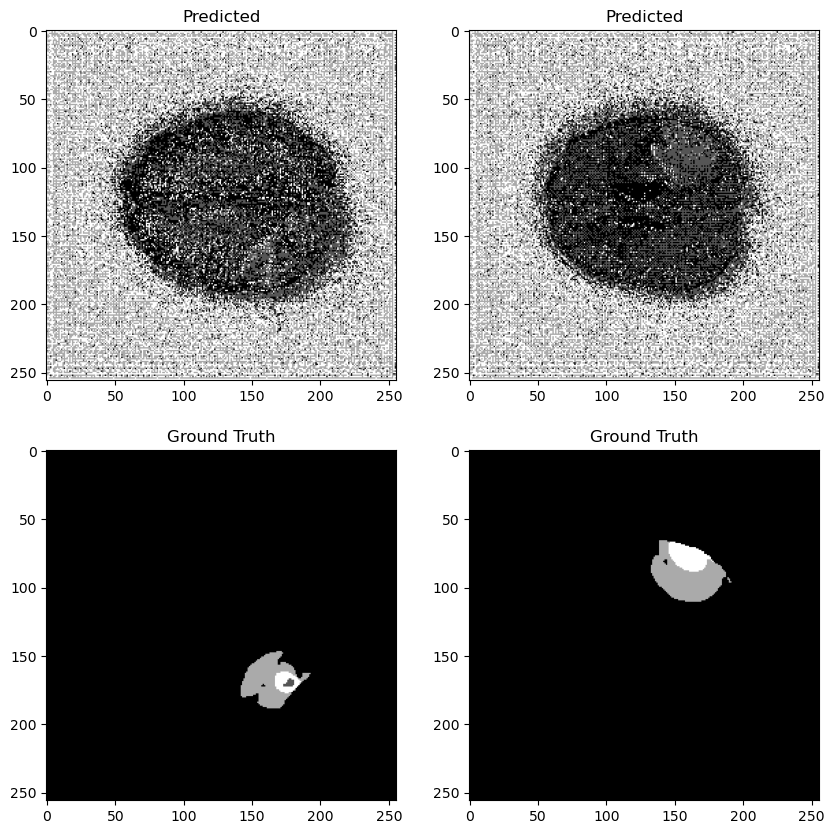

100%|██████████| 554/554 [25:03<00:00,  2.71s/it]



Average Training Loss: 0.7942750518502741

Average Training DSC: [0.98188657 0.09190501 0.28000652 0.21131381]
Average Training ASSD: [  4.37143425 189.49932519 140.35417209  19.83284974]


  0%|          | 0/139 [00:00<?, ?it/s]

Validation Prediction Visualization:


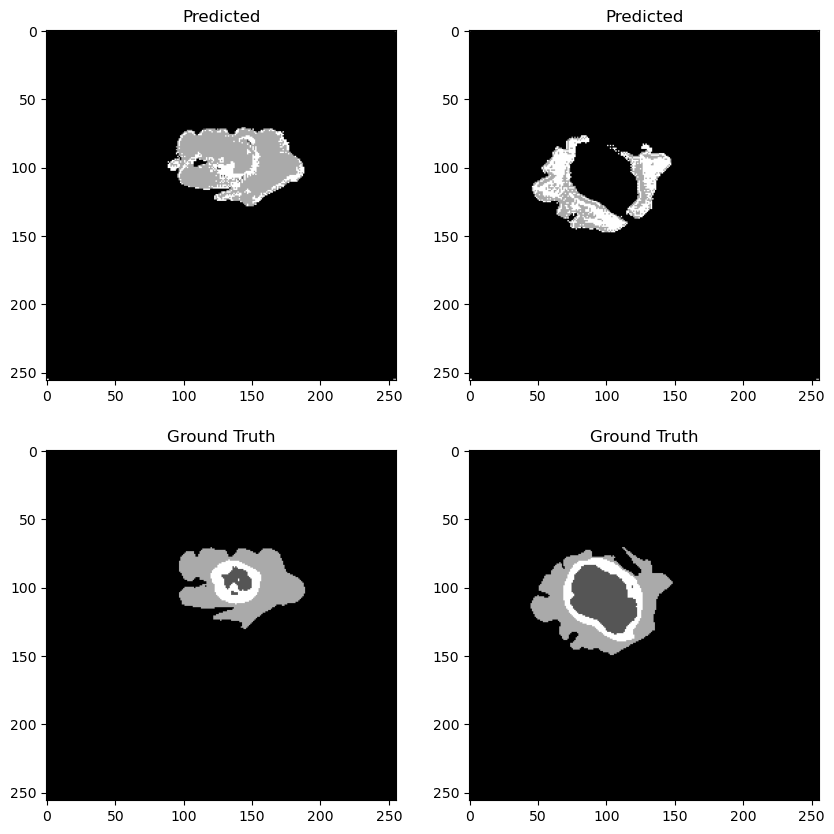

100%|██████████| 139/139 [05:11<00:00,  2.24s/it]


Average Validation Loss: 0.3587156358382685

Average Validation DSC: [0.99732066 0.36476566 0.31789013 0.33031946]
Average Validation ASSD: [  0.64900681 115.45826604 141.46249498  22.72940032]
Epoch 2/50
-------------------------


  0%|          | 0/554 [00:00<?, ?it/s]

Training Prediction Visualization:


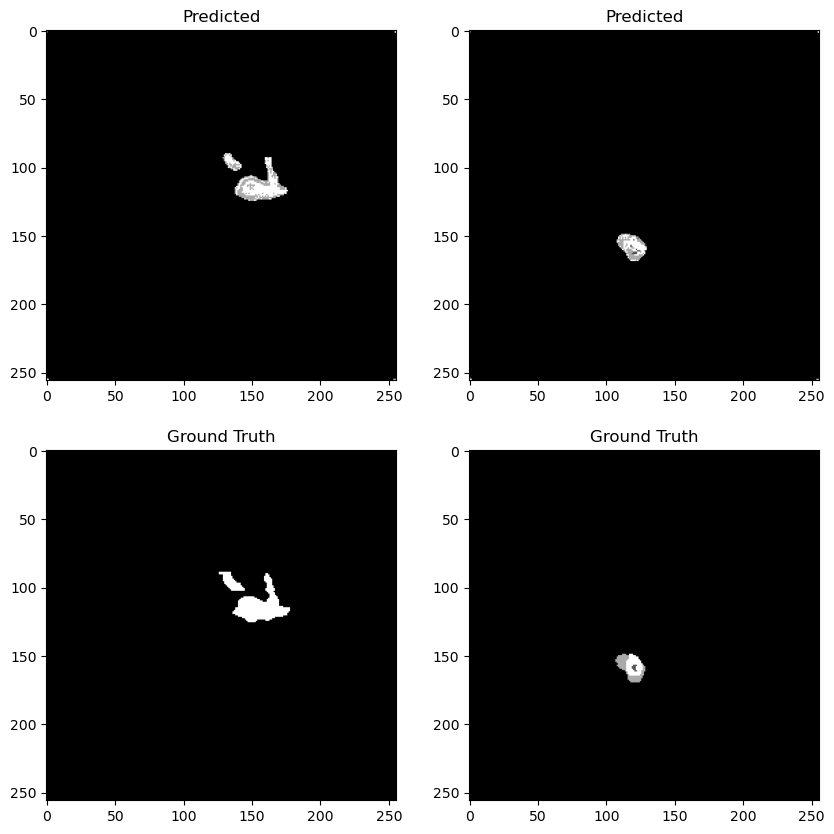

100%|██████████| 554/554 [25:34<00:00,  2.77s/it]



Average Training Loss: 0.22130864082637247

Average Training DSC: [0.99747538 0.3787391  0.34467043 0.30421893]
Average Training ASSD: [  0.600747   116.45396189 139.54419636  22.51567373]


  0%|          | 0/139 [00:00<?, ?it/s]

Validation Prediction Visualization:


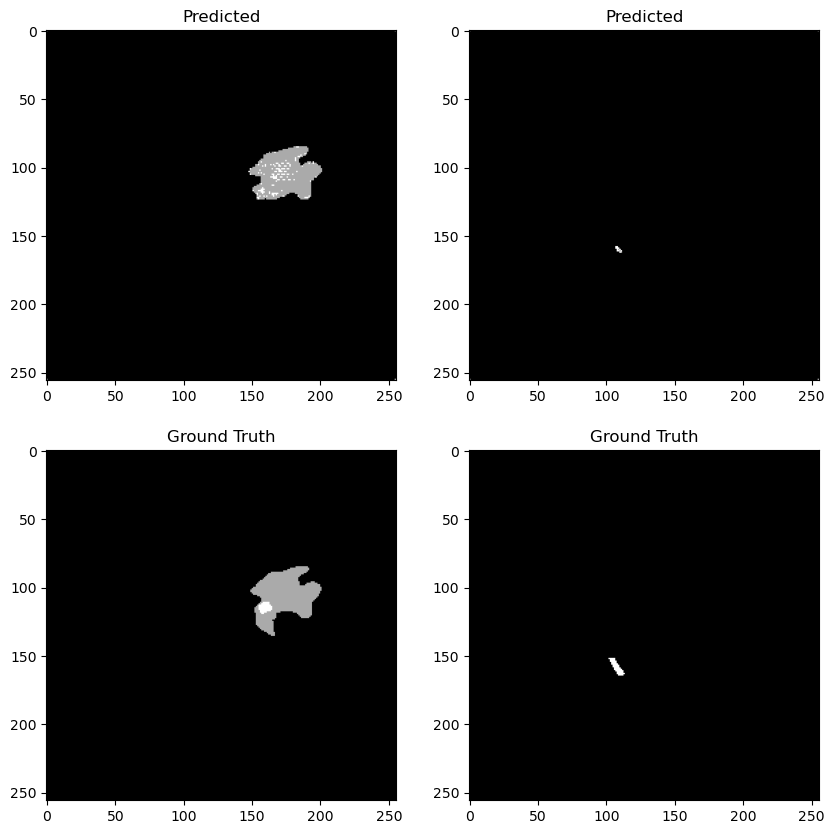

100%|██████████| 139/139 [04:56<00:00,  2.13s/it]


Average Validation Loss: 0.1198616696776246

Average Validation DSC: [0.99770351 0.53382521 0.35739668 0.30299698]
Average Validation ASSD: [  0.53800524  83.33666719 142.00121182  24.17414637]
Epoch 3/50
-------------------------


  0%|          | 0/554 [00:00<?, ?it/s]

Training Prediction Visualization:


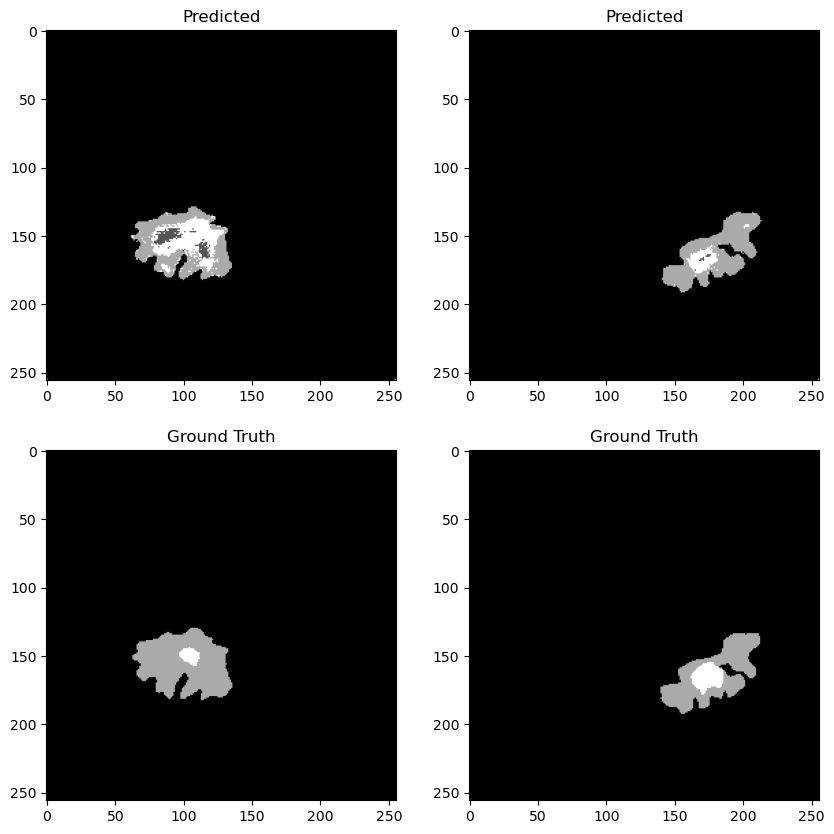

100%|██████████| 554/554 [23:38<00:00,  2.56s/it]



Average Training Loss: 0.10059519580124948

Average Training DSC: [0.99758282 0.50834923 0.35034894 0.34911861]
Average Training ASSD: [  0.56056311  90.12613927 140.18677026  23.03669045]


  0%|          | 0/139 [00:00<?, ?it/s]

Validation Prediction Visualization:


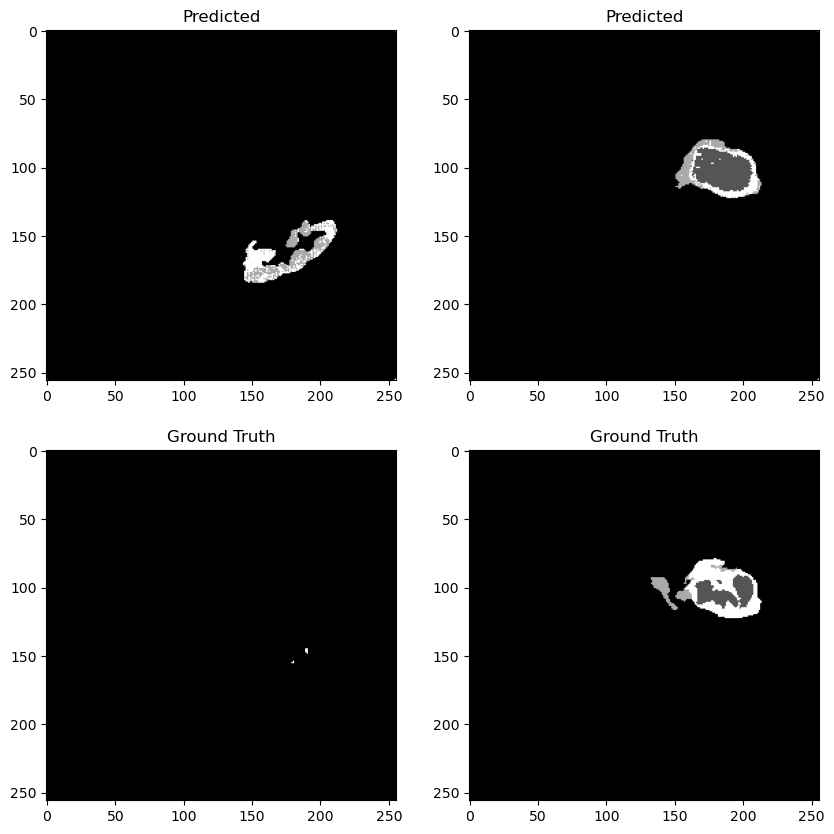

100%|██████████| 139/139 [04:57<00:00,  2.14s/it]


Average Validation Loss: 0.0956086380769023

Average Validation DSC: [0.99750693 0.49135101 0.33440625 0.36149717]
Average Validation ASSD: [  0.62628913  91.74054584 141.00594605  20.18901723]
Epoch 4/50
-------------------------


  0%|          | 0/554 [00:00<?, ?it/s]

Training Prediction Visualization:


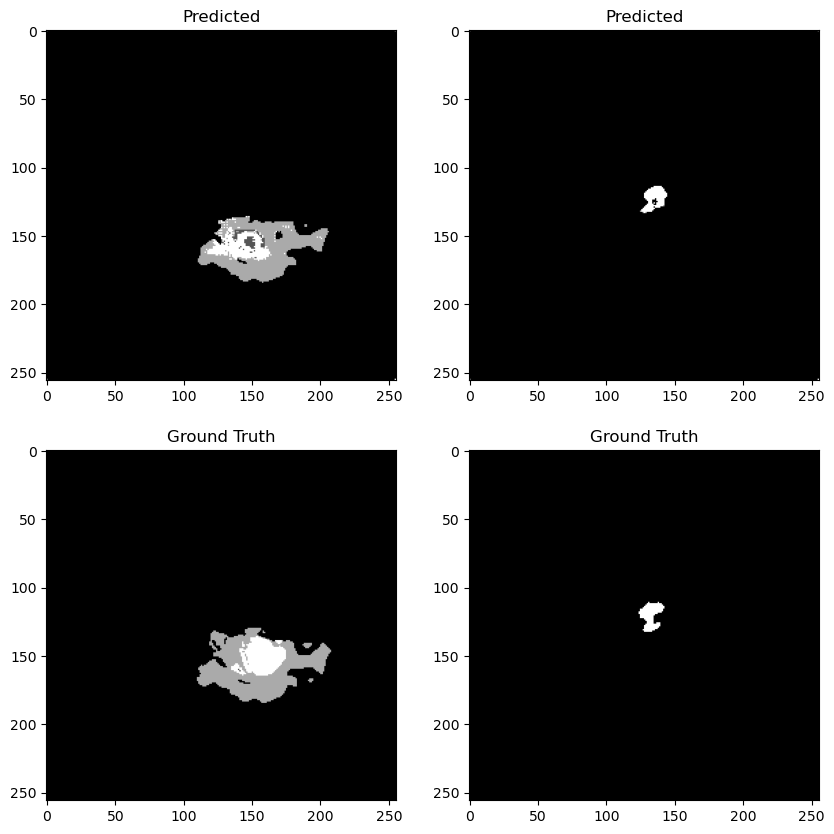

100%|██████████| 554/554 [23:40<00:00,  2.56s/it]



Average Training Loss: 0.06268416969139223

Average Training DSC: [0.99761015 0.41086869 0.3787479  0.3738542 ]
Average Training ASSD: [  0.54464142 119.6485401  133.71470144  24.08717089]


  0%|          | 0/139 [00:00<?, ?it/s]

Validation Prediction Visualization:


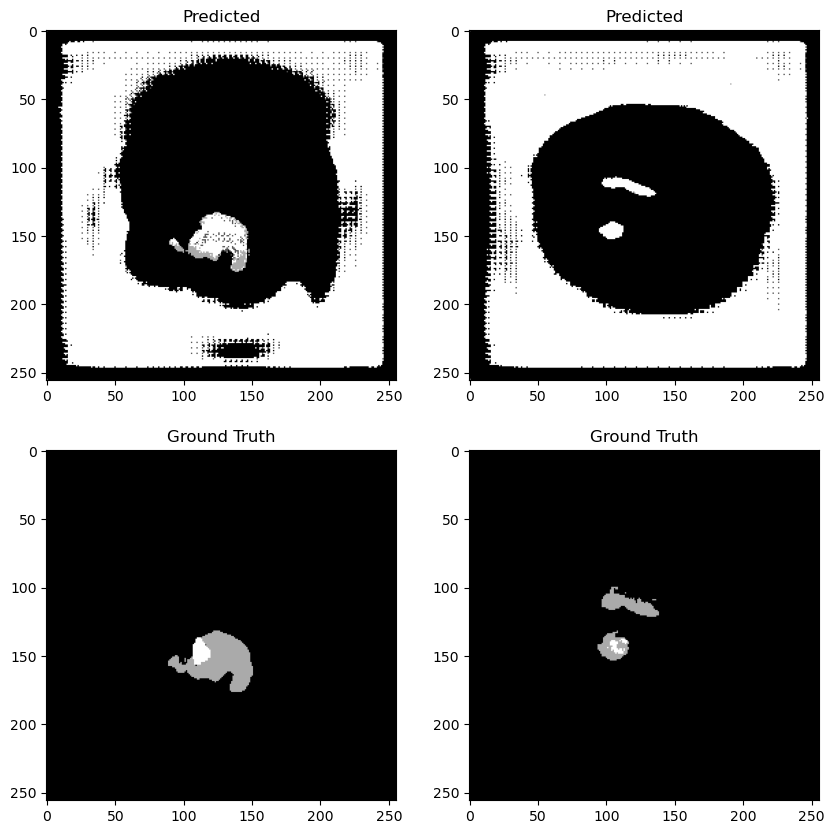

100%|██████████| 139/139 [05:10<00:00,  2.23s/it]


Average Validation Loss: 3.4347185419617796

Average Validation DSC: [0.73154575 0.05793094 0.29006004 0.02289041]
Average Validation ASSD: [  8.11202429 216.14992164 133.85669788  53.56802245]
Epoch 5/50
-------------------------


  0%|          | 0/554 [00:00<?, ?it/s]

Training Prediction Visualization:


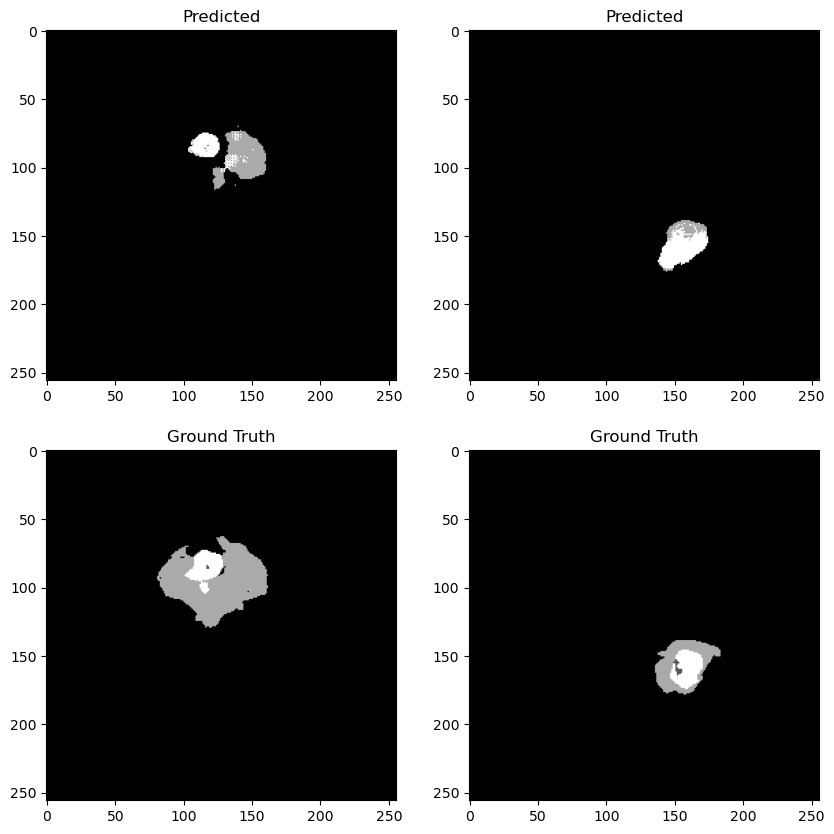

 84%|████████▍ | 468/554 [19:42<03:33,  2.48s/it]

In [ ]:
model = train_model(num_epochs = 50)

In [25]:
import os
import shutil

def remove_ipynb_checkpoints(dir_path):
    for root, dirs, files in os.walk(dir_path):
        if '.ipynb_checkpoints' in dirs:
            shutil.rmtree(os.path.join(root, '.ipynb_checkpoints'))
            print(f'Removed .ipynb_checkpoints from {root}')

remove_ipynb_checkpoints('BraTS_2023_small')